In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from pathlib import Path
import pandas as pd
import joblib

In [ ]:
data_folder_path = Path("./gdrive/MyDrive/Colab Notebooks/MO436/data")
new_format_data_path = Path("./gdrive/MyDrive/Colab Notebooks/MO436/data/Twibot-20-new-format/")
old_format_data_path = Path("./gdrive/MyDrive/Colab Notebooks/MO436/data/Twibot-20-old-format/ETL_Twi20")
embeddings_data_folder_path = data_folder_path/"text_embeddings"



graph_embs_names = joblib.load(data_folder_path/"graph_emb_names.pkl")
numerical_features = joblib.load(data_folder_path/"numerical_features_names.pkl")
categorical_features = joblib.load(data_folder_path/"categorical_features_names.pkl")
tweet_emb_names = joblib.load(data_folder_path/"tweet_emb_names.pkl")
description_emb_names = joblib.load(data_folder_path/"description_emb_names.pkl")
name_emb_names = joblib.load(data_folder_path/"profile_name_emb_names.pkl")
screen_name_emb_names = joblib.load(data_folder_path/"screen_name_emb_names.pkl")

raw_text_embs_names = tweet_emb_names + description_emb_names + name_emb_names + screen_name_emb_names

tsvd_name_embs = [f"tsvd_name_embs{i}" for i in range(20)]
tsvd_screen_name_embs = [f"tsvd_screen_name_embs{i}" for i in range(20)]
tsvd_tweet_embs = [f"tsvd_tweets_embs{i}" for i in range(20)]
tsvd_description_embs = [f"tsvd_description_embs{i}" for i in range(20)]
all_tsvd_embs = tsvd_name_embs + tsvd_screen_name_embs + tsvd_tweet_embs + tsvd_description_embs


ssvd_name_embs = [f"ssvd_name_embs{i}" for i in range(20)]
ssvd_screen_name_embs = [f"ssvd_screen_name_embs{i}" for i in range(20)]
ssvd_tweet_embs = [f"ssvd_tweets_embs{i}" for i in range(20)]
ssvd_description_embs = [f"ssvd_description_embs{i}" for i in range(20)]
all_ssvd_embs = tsvd_name_embs + ssvd_screen_name_embs + ssvd_tweet_embs + ssvd_description_embs

In [ ]:
ssvd_fs_logs = pd.read_parquet(data_folder_path/"feature_selection_ssvd_logs.parquet")
tsvd_fs_logs = pd.read_parquet(data_folder_path/"feature_selection_tsvd_logs.parquet")
raw_fs_logs = pd.read_parquet(data_folder_path/"feature_selection_raw_embs_logs.parquet")

ssvd_no_verified_fs_logs = pd.read_parquet(data_folder_path/"feature_selection_ssvd_no_verified_logs.parquet")
tsvd_no_verified_fs_logs = pd.read_parquet(data_folder_path/"feature_selection_tsvd_no_verified_logs.parquet")

model_3_features = ssvd_fs_logs[lambda d: d.model == "test_set"][lambda d: d.run_index == d.run_index.max()].used_features.apply(eval).iloc[0]
model_2_features = tsvd_fs_logs[lambda d: d.model == "test_set"][lambda d: d.run_index == d.run_index.max()].used_features.apply(eval).iloc[0]
model_1_features = raw_fs_logs[lambda d: d.model == "test_set"][lambda d: d.run_index == d.run_index.max()].used_features.apply(eval).iloc[0]

model_3a_features = ssvd_no_verified_fs_logs[lambda d: d.model == "test_set"][lambda d: d.run_index == d.run_index.max()].used_features.apply(eval).iloc[0]
model_2a_features = tsvd_no_verified_fs_logs[lambda d: d.model == "test_set"][lambda d: d.run_index == d.run_index.max()].used_features.apply(eval).iloc[0]


In [ ]:
profile_features = numerical_features + categorical_features
graph_features = graph_embs_names

all_features_ssvd = profile_features + graph_features + all_ssvd_embs
all_features_tsvd = profile_features + graph_features + all_tsvd_embs
all_features_raw = profile_features + graph_features + raw_text_embs_names

all_features_model_1 = all_features_raw
all_features_model_2 = all_features_tsvd
all_features_model_3 = all_features_ssvd

In [ ]:

train_mask = lambda d: (d["split"] == "train") & (d["random_number"] >= 0.2)
test_mask = lambda d: d["split"] == "test"
support_mask = lambda d: d["split"] == "support"
val_mask = lambda d: (d["split"] == "train") & (d["random_number"] < 0.2)

target = "label"


In [ ]:
df = pd.read_parquet(data_folder_path/"final_scored_dataset.parquet")

# Helping funcs

In [ ]:
!pip install shap -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 7.5 MB/s eta 0:00:00


In [ ]:

from sklearn.base import clone
import numpy as np
import pandas as pd
import shap
from tqdm import tqdm

from toolz import curry
from sklearn.metrics import roc_auc_score

@curry
def _fast_metric_with_ci(data, *, n_samples, ci_level,
                     prediction, target, weight, metric_fn):


    def robust_metric_fn(*args, **kwargs):
      try:
        return metric_fn(*args,**kwargs)
      except:
        return np.nan

    data = data.assign(weight__=lambda df: df[weight] if weight is not None else 1)
    summary = (
        data
        .assign(
            prediction=lambda df: (1000 * df[prediction]).round()/1000,
        )
        .groupby(["weight__", 'prediction', target])
        .size().to_frame("sample_size")
        .reset_index()
    )

    estimate = (
        summary
        .assign(weight__=lambda df: df["weight__"] * df['sample_size'])
        .pipe(lambda df: robust_metric_fn(df[target], df['prediction'], sample_weight=df['weight__']))
    )

    if ci_level is not None:
      bs_values = [
          summary
          .assign(weight__=lambda df: df["weight__"] * np.random.poisson(df['sample_size']))
          .pipe(lambda df: robust_metric_fn(df[target], df['prediction'], sample_weight=df['weight__']))
      for _ in range(n_samples)]

      lo, hi = bootstrap_ci(estimate, bs_values, ci_level=ci_level)
    else:
      lo, hi = estimate, estimate

    return pd.Series(dict(
        estimate=estimate,
        ci_upper=hi,
        ci_lower=lo,
        model=prediction
    ))


def bootstrap_ci(sample_estimate, bootstrap_estimates, ci_level=0.95):
    lo = 2 * sample_estimate - np.quantile(bootstrap_estimates, (1 + ci_level) / 2)
    hi = 2 * sample_estimate - np.quantile(bootstrap_estimates, (1 - ci_level) / 2)
    return lo, hi



@curry
def _fast_delta_metric_with_ci(data, baseline, challenger, *, n_samples, ci_level,
                           target, weight, metric_fn):

    def robust_metric_fn(*args, **kwargs):
      try:
        return metric_fn(*args,**kwargs)
      except:
        return np.nan

    data = data.assign(weight__=lambda df: df[weight] if weight is not None else 1)

    summary = (
        data
        .assign(**{
            baseline: lambda df: (1000 * df[baseline]).round()/1000,
            challenger: lambda df: (1000 * df[challenger]).round()/1000,
        })
        .groupby(["weight__", baseline, challenger, target])
        .size().to_frame("sample_size")
        .reset_index()
    )


    def delta_metric(df):
        challenger_auc = robust_metric_fn(df[target], df[challenger], sample_weight=df['weight__'])
        baseline_auc = robust_metric_fn(df[target], df[baseline], sample_weight=df['weight__'])
        return challenger_auc - baseline_auc

    estimate = (
        summary
        .assign(weight__=lambda df: df["weight__"] * df['sample_size'])
        .pipe(delta_metric)
    )

    if ci_level is not None:

      bs_values = [
          summary
          .assign(weight__=lambda df: df["weight__"] * np.random.poisson(df['sample_size']))
          .pipe(delta_metric)
      for _ in range(n_samples)]

      lo, hi = bootstrap_ci(estimate, bs_values, ci_level=ci_level)
    else:
      lo, hi = estimate, estimate

    return pd.Series(dict(
        estimate=estimate,
        ci_upper=hi,
        ci_lower=lo,
        model=challenger
    ))


@curry
def fast_delta_metric_with_ci(data, baseline, challengers, target, metric_fn, *, n_samples=30, ci_level=0.95, weight=None):

    fn = _fast_delta_metric_with_ci(
        baseline=baseline,
        n_samples=n_samples,
        ci_level=ci_level,
        target=target,
        weight=weight,
        metric_fn=metric_fn
      )

    all_values = [fn(data=data,challenger=c) for c in challengers]

    return pd.DataFrame(all_values)

@curry
def fast_metric_with_ci(data, predictions, target, metric_fn, *, n_samples=30, ci_level=0.95, weight=None):

    fn = _fast_metric_with_ci(
        target=target,
        n_samples=n_samples,
        ci_level=ci_level,
        weight=weight,
        metric_fn=metric_fn
      )

    all_values = [fn(data=data,prediction=p) for p in predictions]

    return pd.DataFrame(all_values)

def log_odds_to_proba(x):
  return 1/(1+np.exp(-x))

def proba_to_log_odds(p):
  return np.log(p/(1-p))


def backwards_shap_feature_selection(
    model,
    df_train,
    df_val,
    candidate_features_for_removal,
    target,
    null_hypothesis = "feature_is_good",
    fixed_features=[],
    n_features_sample=None,
    extra_validation_sets = {},
    sample_weight=None,
    metric_fn = roc_auc_score,
    bootstrap_samples=20,
    ci_level=0.8,
    max_iter = 10,
    patience=0,
    max_removals_per_run=None
):

  """
  """

  #TODO:
  #check key names
  valid_nulls = ["feature_is_good","feature_is_bad"]
  if not null_hypothesis in valid_nulls:
      raise(ValueError(f"null_hypothesis should be one of {valid_nulls}, got {null_hypothesis}"))

  keys_intersections = set(extra_validation_sets.keys()) & set(candidate_features_for_removal + fixed_features)
  if keys_intersections:
    raise ValueError(f"extra_validation_sets names should not match names of features. Found {keys_intersections}")

  keys_intersections = keys_intersections & set(["metric", "error-contribution"])
  if keys_intersections:
    raise ValueError(f"extra_validation_sets names or feature names should not be 'metric' or 'error-contribution'. Found {keys_intersections}")

  all_logs = []
  p=0
  for i in tqdm(range(max_iter)):

    #set all features
    all_features = candidate_features_for_removal + fixed_features

    if len(all_features) == 0:
      break

    if (n_features_sample is None) or (len(all_features) <= n_features_sample):
      features_to_use = all_features
    else:
      features_to_use = np.random.choice(all_features, n_features_sample, replace=False)

    run_logs = _backwards_shap_feature_selection(
        model=clone(model),
        df_train=df_train,
        df_val=df_val,
        all_features=features_to_use,
        extra_validation_sets=extra_validation_sets,
        target=target,
        sample_weight=sample_weight,
        metric_fn=metric_fn,
        bootstrap_samples=bootstrap_samples,
        ci_level=ci_level,
    )

    statsig_good_features = (
          run_logs
          [lambda d: d["ci_upper"] < 0]
          [lambda d: d["metric"] == "error-contribution"]
          [lambda d: ~d["model"].isin(fixed_features)]
          .sort_values(by = "ci_upper", ascending=False)
      )

    statsig_bad_features = (
          run_logs
          [lambda d: d["ci_upper"] < 0]
          [lambda d: d["metric"] == "error-contribution"]
          [lambda d: ~d["model"].isin(fixed_features)]
          .sort_values(by = "ci_upper", ascending=False)
      )

    statsig_null_features = (
          run_logs
          [lambda d: d["ci_upper"] < 0]
          [lambda d: d["metric"] == "error-contribution"]
          [lambda d: ~d["model"].isin(fixed_features)]
          .sort_values(by = "ci_upper", ascending=False)
      )

    if null_hypothesis == "feature_is_good":
      features_to_remove = (
          run_logs
          [lambda d: d["ci_lower"] > 0]
          [lambda d: d["metric"] == "error-contribution"]
          [lambda d: ~d["model"].isin(fixed_features)]
          .sort_values(by = "ci_lower", ascending=False)
      )
    else:
      features_to_remove = (
          run_logs
          [lambda d: d["ci_upper"] > 0]
          [lambda d: d["metric"] == "error-contribution"]
          [lambda d: ~d["model"].isin(fixed_features)]
          .sort_values(by = "ci_upper", ascending=False)
      )


    if max_removals_per_run is not None:
      features_to_remove = features_to_remove.iloc[:max_removals_per_run]

    features_to_remove = features_to_remove["model"].values.tolist() #model means the model without the feature

    run_logs["run_index"] = i
    run_logs["n_features"] = (run_logs["metric"] == "error-contribution").sum()
    run_logs["removed_features"] = str(features_to_remove)
    run_logs["n_features_removed"] = len(features_to_remove)
    all_logs.append(run_logs)

    if len(features_to_remove) == 0:
      if patience:
        if p >= patience:
          break
        else:
          p+=1
          continue
      else:
        break

    #update features for the next iteration
    candidate_features_for_removal = [i for i in candidate_features_for_removal if not i in features_to_remove]

    #update counters
    p=0

  #calculate fs logs for full set of features in case of sub sampling
  if (n_features_sample is not None) and (len(all_features) > n_features_sample):
      run_logs = _backwards_shap_feature_selection(
          model=clone(model),
          df_train=df_train,
          df_val=df_val,
          all_features=all_features,
          extra_validation_sets=extra_validation_sets,
          target=target,
          sample_weight=sample_weight,
          metric_fn=metric_fn,
          bootstrap_samples=bootstrap_samples,
          ci_level=ci_level,
      )
      run_logs["run_index"] = i + 1
      run_logs["n_features"] = len(all_features)
      run_logs["removed_features"] = str([])
      run_logs["n_features_removed"] = 0
      all_logs.append(run_logs)

  return pd.concat(all_logs, ignore_index=True)


def _backwards_shap_feature_selection(
    model,
    df_train,
    df_val,
    all_features,
    extra_validation_sets,
    target,
    sample_weight,
    metric_fn,
    bootstrap_samples,
    ci_level,
):

  #train model
  model.fit(
      df_train[all_features],
      df_train[target],
      sample_weight=sample_weight
  )


  #calculate shap
  explainer = shap.TreeExplainer(model)
  shap_values_val = explainer.shap_values(df_val[all_features])[-1]

  #make raw preds
  raw_preds_val = proba_to_log_odds(model.predict_proba(df_val[all_features])[:,-1])

  #score without feature
  scores_df = pd.DataFrame(
      log_odds_to_proba(raw_preds_val.reshape(-1,1) - shap_values_val),
      columns = all_features
  )

  #add extra columns
  scores_df["val_set"] = raw_preds_val
  scores_df[target] = df_val[target].values
  if sample_weight is not None:
    df_val[sample_weight].values


  #deltas
  error_contributions_with_ci = fast_delta_metric_with_ci(
      scores_df,
      baseline="val_set",
      challengers=all_features,
      n_samples=bootstrap_samples,
      ci_level=ci_level,
      target=target,
      weight=sample_weight,
      metric_fn = metric_fn
    ).assign(metric="error-contribution")

  #current setup metric
  metric = fast_metric_with_ci(
      scores_df,
      predictions=["val_set"],
      n_samples=bootstrap_samples,
      ci_level=ci_level,
      target=target,
      weight=sample_weight,
      metric_fn = metric_fn
    ).assign(metric="metric", used_features=str(all_features))

  extra_val_logs = []
  for k,d in extra_validation_sets.items():
    extra_val_logs.append(
        fast_metric_with_ci(
          d.assign(**{k:lambda d: model.predict_proba(d[all_features])[:,-1], "weight__":lambda d: d[sample_weight] if sample_weight is not None else 1}),
          predictions=[k],
          n_samples=bootstrap_samples,
          ci_level=ci_level,
          target=target,
          weight="weight__",
          metric_fn = metric_fn
      ).assign(metric="metric", used_features=str(all_features))
    )



  return pd.concat([error_contributions_with_ci, metric, *extra_val_logs], ignore_index = True)

# TODO: implement mixed selection trataegy (keep good features for next runs when sampling)
def make_error_contribution(
      data, model, features, target, metric_fn, *, sample_weight=None, baseline_name="baseline", ci_level=0.95, bootstrap_samples=30,
      ):
    #calculate shap
    explainer = shap.TreeExplainer(model)
    shap_values_val = explainer.shap_values(data[features])[-1]

    #make raw preds
    raw_preds_val = proba_to_log_odds(model.predict_proba(data[features])[:,-1])

    #score without feature
    scores_df = pd.DataFrame(
        log_odds_to_proba(raw_preds_val.reshape(-1,1) - shap_values_val),
        columns = features
    )

    #add extra columns
    scores_df[baseline_name] = raw_preds_val
    scores_df[target] = data[target].values
    if sample_weight is not None:
      scores_df[sample_weight] = data[sample_weight].values


    #deltas
    error_contributions_with_ci = fast_delta_metric_with_ci(
        scores_df,
        baseline=baseline_name,
        challengers=features,
        n_samples=bootstrap_samples,
        ci_level=ci_level,
        target=target,
        weight=sample_weight,
        metric_fn = metric_fn
      ).assign(metric="error-contribution")
    return error_contributions_with_ci

# Validation

In [ ]:
from sklearn.metrics import matthews_corrcoef, roc_auc_score, average_precision_score, f1_score, balanced_accuracy_score, accuracy_score, precision_score, recall_score

In [ ]:
# fast_metric_with_ci(data, predictions, target, *, n_samples=100, ci_level=0.95, weight='weight', metric_fn = roc_auc_score)
# fast_delta_metric_with_ci(data, baseline, challengers, target, *, n_samples=100, ci_level=0.95, weight='weight', metric_fn = roc_auc_score)
from functools import partial

continuous_validation_metrics = {
    "ROC AUC":roc_auc_score,
    "Avg Precision":average_precision_score,
}

threshold_validation_metrics = {
    "MCC": matthews_corrcoef,
    "F1-Score":f1_score,
    "balanced_accuracy":balanced_accuracy_score,
    "accuracy":accuracy_score,
    "precision":precision_score,
    "recall":recall_score
}

predictions = [
    "pipeline_1_score",
    "pipeline_2_score",
    "pipeline_3_score",
    "pipeline_2a_score",
    "pipeline_3a_score",
]


def score_all(df, validation_metrics, groups, predictions, **kwargs):
  all_dfs = []
  for k,v in tqdm(validation_metrics.items()):
    metric_fn = fast_metric_with_ci(predictions=predictions, target=target, metric_fn = v, **kwargs)
    metric_df = (
        df
        # .assign(binary_target = lambda d: d[target].factorize()[0])
        .groupby(groups)
        .apply(lambda d: metric_fn(d))
        .reset_index()
        .assign(metric = k)
    )
    all_dfs.append(metric_df)
  return pd.concat(all_dfs, ignore_index=True)

# avg_precision_fn = fast_metric_with_ci(predictions, target, n_samples=100, ci_level=0.95, weight='weight', metric_fn = roc_auc_score)
# auc_fn = fast_metric_with_ci(predictions, target, n_samples=100, ci_level=0.95, weight='weight', metric_fn = roc_auc_score)
# auc_fn = fast_metric_with_ci(predictions, target, n_samples=100, ci_level=0.95, weight='weight', metric_fn = roc_auc_score)

# delta(baseline, challenger, n_samples=100, ci_level=0.95, target='target', weight='weight', metric_fn = roc_auc_score)

In [ ]:
continuous_metrics_df = (
    df
    # [lambda d: d.verified == 0]
    # .assign(**{i:lambda d, i=i: np.where(d["verified"] == 1, 0, 1-d[i]) for i in predictions})
    .assign(**{i:lambda d, i=i: 1-d[i] for i in predictions})
    .assign(**{target:lambda d: d[target].replace({"bot":1,"human":0})})
    .pipe(score_all, validation_metrics=continuous_validation_metrics, groups = ["split"], predictions=predictions)
)

threshold_metrics_df = (
    df
    # [lambda d: d.verified == 0]
    # .assign(**{i:lambda d, i=i: np.where(d["verified"] == 1, 0, 1-d[i]) for i in predictions})
    .assign(**{i:lambda d, i=i: 1-d[i] for i in predictions})
    .assign(**{target:lambda d: d[target].replace({"bot":1,"human":0})})
    .assign(**{i:lambda d, i=i: (d[i] > 0.5).astype(int) for i in predictions})
    .pipe(score_all, validation_metrics=threshold_validation_metrics, groups = ["split"], predictions = predictions)
)
metrics_df = pd.concat([threshold_metrics_df, continuous_metrics_df])

100%|██████████| 6/6 [00:08<00:00,  1.48s/it]


In [ ]:
df.groupby(["split"])["label"].value_counts(normalize=1).to_frame().rename(columns={"label":"freq"}).reset_index().pivot(columns = "label", index = "split")

freq          
label       bot     human
split                    
test   0.540997  0.459003
train  0.561247  0.438753

In [ ]:
metrics_df.query("split =='test'")[["split","metric","ci_lower","estimate","ci_upper","model"]].pivot(columns="metric", index="model",
                                                                                                      values=[
                                                                                                          # "ci_lower",
                                                                                                          "estimate",
                                                                                                          # "ci_upper"
                                                                                                          ]
                                                                                                      ).T

model                       pipeline_1_score  pipeline_2_score  \
         metric                                                  
estimate Avg Precision              0.930538          0.934005   
         F1-Score                   0.874818          0.871795   
         MCC                        0.712783          0.706174   
         ROC AUC                    0.928896          0.929784   
         accuracy                   0.854607          0.852071   
         balanced_accuracy          0.847063          0.845138   
         precision                  0.818801          0.820690   
         recall                     0.939063          0.929688   

model                       pipeline_2a_score  pipeline_3_score  \
         metric                                                   
estimate Avg Precision               0.900650          0.934787   
         F1-Score                    0.820551          0.873715   
         MCC                         0.589625          0.710978   
         ROC AUC                     0.890644          0.931437   
         accuracy                    0.796281          0.854607   
         balanced_accuracy           0.790506          0.847901   
         precision                   0.783784          0.824100   
         recall                      0.860938          0.929688   

model                       pipeline_3a_score  
         metric                                
estimate Avg Precision               0.902489  
         F1-Score                    0.832457  
         MCC                         0.620094  
         ROC AUC                     0.892068  
         accuracy                    0.811496  
         balanced_accuracy           0.806661  
         precision                   0.801737  
         recall                      0.865625

# Plots

## Time robustness analysis

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# plt.title(f"test score distribution for classes in pipe 1")

In [ ]:
from lightgbm import LGBMClassifier
df = df.assign(out_of_time = lambda d: d.tenure < 1000)

oot_mask = lambda d: d.out_of_time
not_oot_mask = lambda d: ~d.out_of_time

In [ ]:
df["truncated_created_at"] = df.created_at.dt.to_period('Q').dt.to_timestamp()

Converting to PeriodArray/Index representation will drop timezone information.


<Axes: xlabel='truncated_created_at', ylabel='Count'>

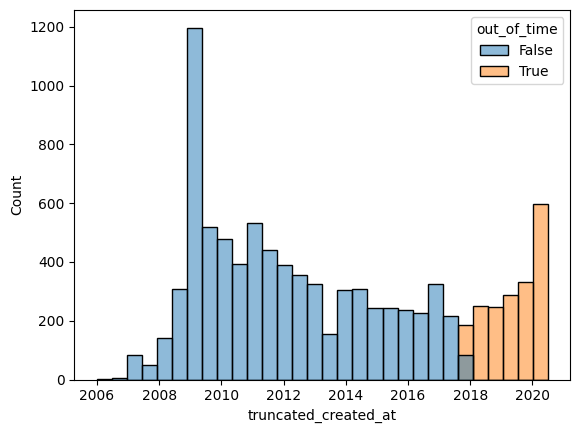

In [ ]:
sns.histplot(data=df, x="truncated_created_at", hue="out_of_time", bins = 30)

In [ ]:
oot_model = LGBMClassifier(n_jobs=-1, n_estimators = 200, learning_rate = 0.01).fit(df[not_oot_mask][model_3_features], df[not_oot_mask][target])
df["oot_score"] = oot_model.predict_proba(df[model_3_features])[:,-1]
oot_model_no_verified = LGBMClassifier(n_jobs=-1, n_estimators = 200, learning_rate = 0.01).fit(df[not_oot_mask][model_3a_features], df[not_oot_mask][target])
df["oot_score_no_verified"] = oot_model_no_verified.predict_proba(df[model_3a_features])[:,-1]

[LightGBM] [Info] Number of positive: 3532, number of negative: 4030
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13529
[LightGBM] [Info] Number of data points in the train set: 7562, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.467072 -> initscore=-0.131902
[LightGBM] [Info] Start training from score -0.131902
[LightGBM] [Info] Number of positive: 3532, number of negative: 4030
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17603
[LightGBM] [Info] Number of data points in the train set: 7562, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.467072 -> initscore=-0.131902
[LightGBM] [Info] Start training from score -0.131902


In [ ]:
oot_predictions = ["oot_score","oot_score_no_verified"]
oot_continuous_metrics_df = (
    df
    # [lambda d: d.verified == 0]
    # .assign(**{i:lambda d, i=i: np.where(d["verified"] == 1, 0, 1-d[i]) for i in predictions})
    .assign(**{i:lambda d, i=i: 1-d[i] for i in oot_predictions})
    .assign(**{target:lambda d: d[target].replace({"bot":1,"human":0})})
    .pipe(score_all, predictions = oot_predictions, validation_metrics=continuous_validation_metrics, groups = "truncated_created_at", ci_level=None)
)

oot_threshold_metrics_df = (
    df
    # [lambda d: d.verified == 0]
    # .assign(**{i:lambda d, i=i: np.where(d["verified"] == 1, 0, 1-d[i]) for i in predictions})
    .assign(**{i:lambda d, i=i: 1-d[i] for i in predictions})
    .assign(**{target:lambda d: d[target].replace({"bot":1,"human":0})})
    .assign(**{i:lambda d, i=i: (d[i] < 0.5).astype(int) for i in oot_predictions})
    .pipe(score_all, predictions = oot_predictions, validation_metrics=threshold_validation_metrics, groups = "truncated_created_at", ci_level=None)
)
oot_metrics_df = pd.concat([oot_threshold_metrics_df, oot_continuous_metrics_df])

 50%|█████     | 1/2 [00:01<00:01,  1.03s/it]No positive class found in y_true, recall is set to one for all thresholds.
No positive class found in y_true, recall is set to one for all thresholds.
No positive class found in y_true, recall is set to one for all thresholds.
No positive class found in y_true, recall is set to one for all thresholds.
 17%|█▋        | 1/6 [00:01<00:05,  1.12s/it]F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
 67%|██████▋   | 4/6 [00:09<00:04,  2.12s/it]Precision

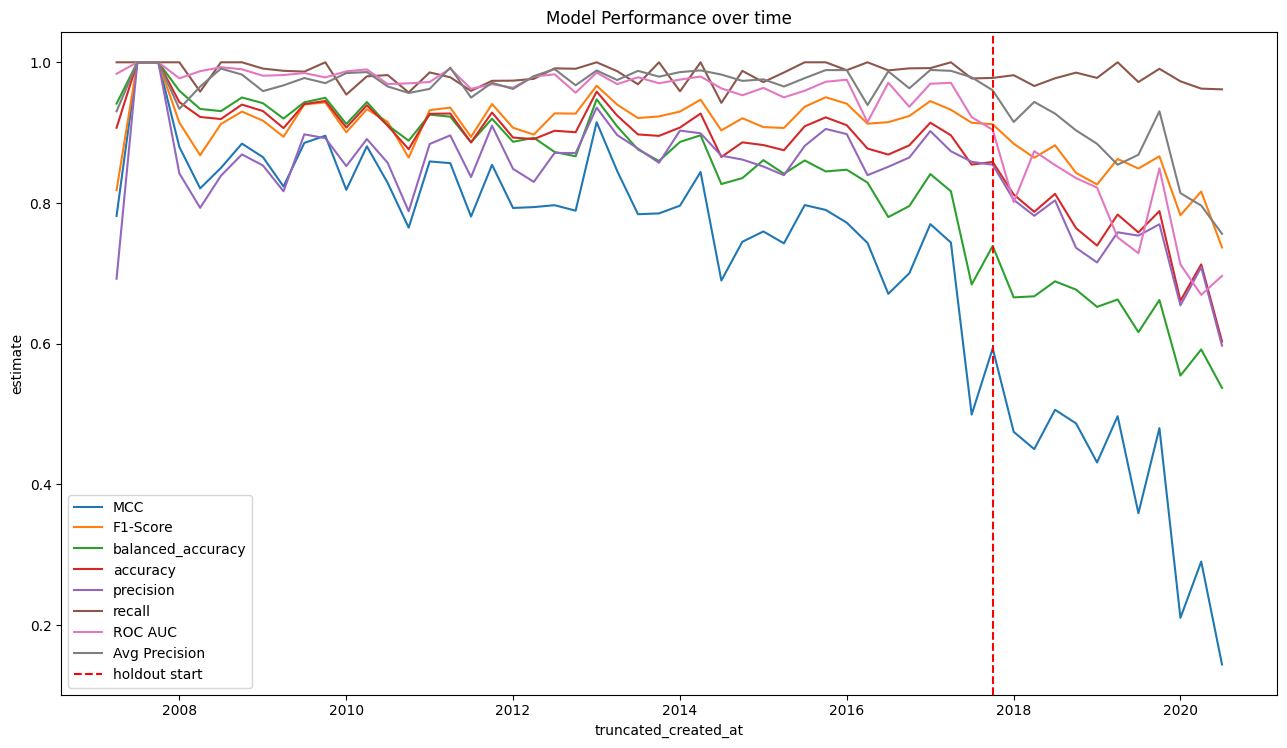

In [ ]:
(
    oot_metrics_df
    [lambda d: d.truncated_created_at > "2007-01-01"]
    [lambda d: d.model == "oot_score"]
    .reset_index()
    .pipe(sns.lineplot, x="truncated_created_at", y="estimate", hue="metric")
)

plt.axvline(df[oot_mask]["truncated_created_at"].min(), color = "red", linestyle = "--", label="holdout start")
plt.title("Model Performance over time")
plt.legend()
plt.subplots_adjust(-1,-.5)

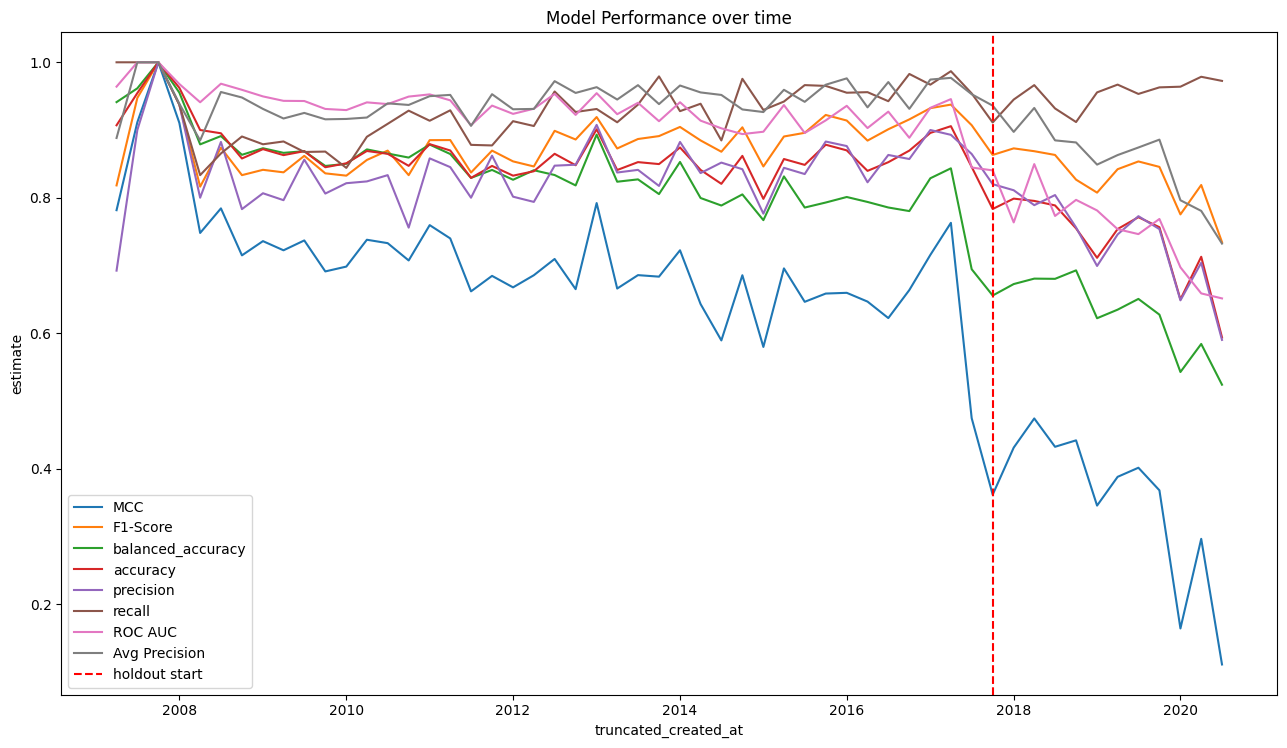

In [ ]:
(
    oot_metrics_df
    [lambda d: d.truncated_created_at > "2007-01-01"]
    [lambda d: d.model == "oot_score_no_verified"]
    .reset_index()
    .pipe(sns.lineplot, x="truncated_created_at", y="estimate", hue="metric")
)

plt.axvline(df[oot_mask]["truncated_created_at"].min(), color = "red", linestyle = "--", label="holdout start")
plt.title("Model Performance over time")
plt.legend()
plt.subplots_adjust(-1,-.5)

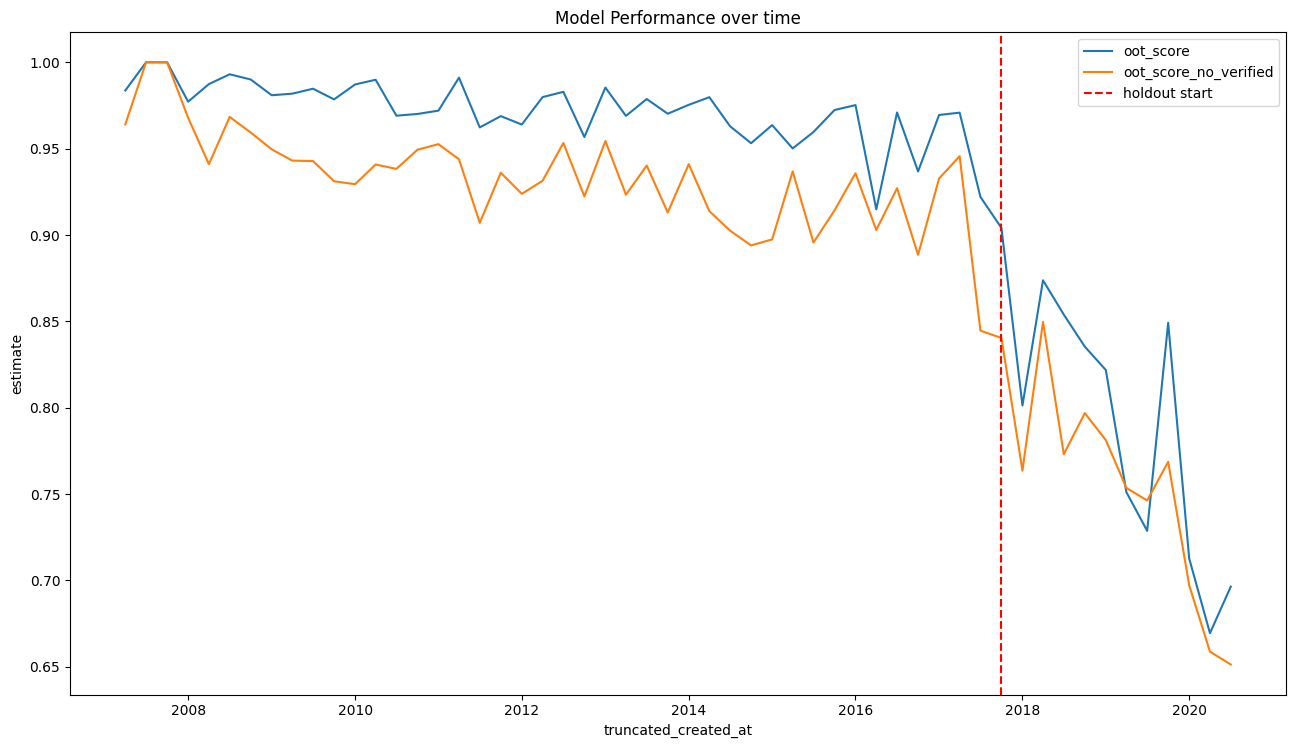

In [ ]:
(
    oot_metrics_df
    [lambda d: d.truncated_created_at > "2007-01-01"]
    [lambda d: d.metric == "ROC AUC"]
    .reset_index()
    .pipe(sns.lineplot, x="truncated_created_at", y="estimate", hue="model")
)

plt.axvline(df[oot_mask]["truncated_created_at"].min(), color = "red", linestyle = "--", label="holdout start")
plt.title("Model Performance over time")
plt.legend()
plt.subplots_adjust(-1,-.5)

In [ ]:
error_contributions = (
    df
    .groupby("truncated_created_at")
    .apply(lambda d: make_error_contribution(
                      data=d,
                      model=oot_model,
                      features=model_3_features,
                      target=target,
                      metric_fn = roc_auc_score,
                      sample_weight=None,
                      baseline_name="baseline",
                      ci_level=None,
                      bootstrap_samples=30,
                      )
    )
)


error_contributions_no_verified = (
    df
    .groupby("truncated_created_at")
    .apply(lambda d: make_error_contribution(
                      data=d,
                      model=oot_model_no_verified,
                      features=model_3a_features,
                      target=target,
                      metric_fn=roc_auc_score,
                      sample_weight=None,
                      baseline_name="baseline",
                      ci_level=None,
                      bootstrap_samples=30,
                      )
    )
)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary clas

In [ ]:
def with_feature_group(df):
  df["feature_group"] = np.nan
  df.loc[lambda d: d.model.isin(tweet_emb_names + tsvd_tweet_embs + ssvd_tweet_embs), "feature_group"] = "tweet_embbeding"
  df.loc[lambda d: d.model.isin(description_emb_names + tsvd_description_embs + ssvd_description_embs), "feature_group"] = "description_embbeding"
  df.loc[lambda d: d.model.isin(name_emb_names + tsvd_name_embs + ssvd_name_embs), "feature_group"] = "name_embbeding"
  df.loc[lambda d: d.model.isin(screen_name_emb_names + tsvd_screen_name_embs + ssvd_screen_name_embs), "feature_group"] = "screen_name_embbeding"
  df.loc[lambda d: d.model.isin(categorical_features), "feature_group"] = "categorical"
  df.loc[lambda d: d.model.isin(numerical_features), "feature_group"] = "numerical"
  df.loc[lambda d: d.model.isin(graph_features), "feature_group"] = "network_features"
  return df




pd.options.plotting.backend = 'plotly'

(
    error_contributions
    .pipe(with_feature_group)
    .reset_index()
    .groupby(["truncated_created_at","feature_group"])
    .mean()
    .reset_index()
    .plot.line(x="truncated_created_at", color="feature_group", y="estimate", title="error contribution over time (3)", width=1200, height=600)
)

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


In [ ]:
(
    error_contributions_no_verified
    .pipe(with_feature_group)
    .reset_index()
    .groupby(["truncated_created_at","feature_group"])
    .mean()
    .reset_index()
    .plot.line(x="truncated_created_at", color="feature_group", y="estimate", title="error contribution over time (3a)", width=1200, height=600)
)

<ipython-input-53-be87cc5b5a3d>:6: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



## Score distributions

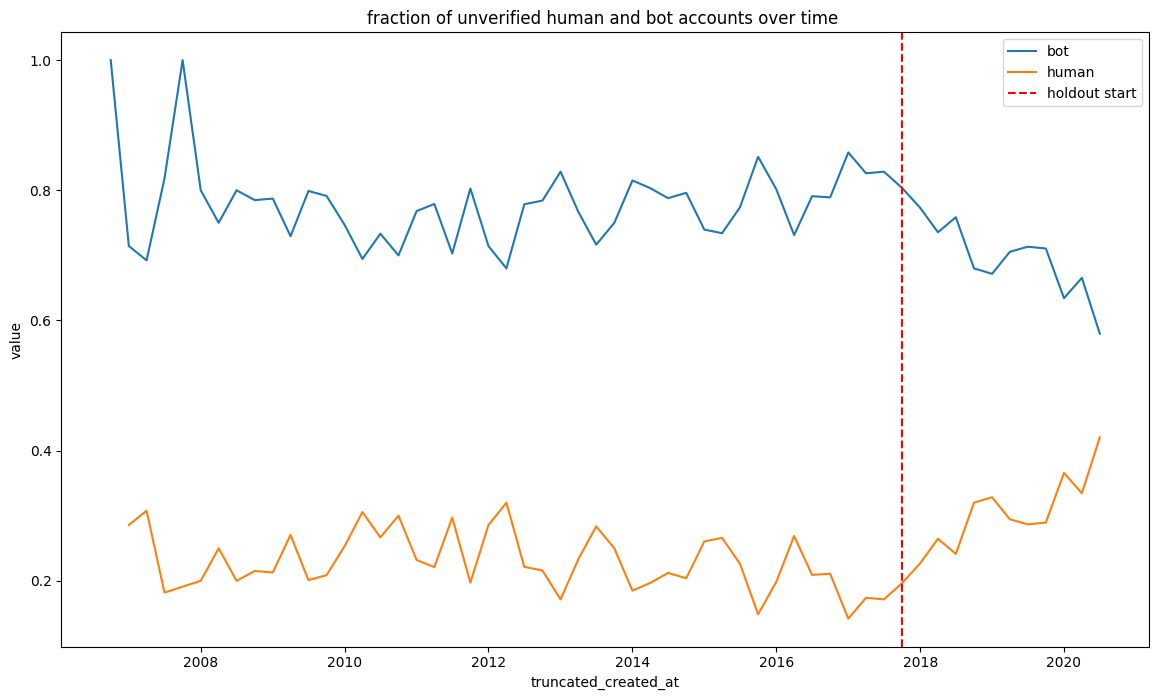

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

def flatten_columns(df):
  df.columns = df.columns.map(lambda d: "-".join(d))
  return df
(
    df
    .groupby(["truncated_created_at","verified"])
    [target]
    .value_counts(normalize=1)
    .to_frame()
    .rename(columns = {"label":"value"})
    .reset_index()
    # .pivot(index = ["truncated_created_at", "verified"], columns = ["label"], values = ["value"])
    # .pipe(flatten_columns)
    .reset_index()
    .assign(verified = lambda d: d.verified.replace({1:"verified",0:"unverified"}))
    [lambda d: d.verified =="unverified"]
    .pipe(sns.lineplot, x="truncated_created_at", y="value", hue="label")
)

plt.axvline(df[oot_mask]["truncated_created_at"].min(), color = "red", linestyle = "--", label="holdout start")
plt.title("fraction of unverified human and bot accounts over time ")
plt.legend()
plt.subplots_adjust(-.8,-.4)

Text(0.5, 1.0, 'test score distribution for classes in pipe 1')

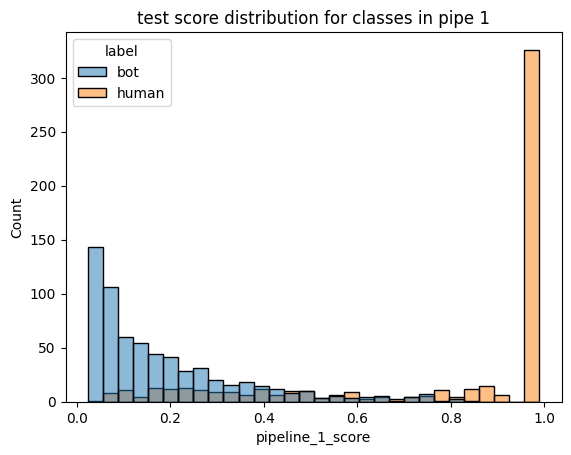

In [ ]:

sns.histplot(data=df[test_mask], x="pipeline_1_score", hue="label", bins = 30)
plt.title(f"test score distribution for classes in pipe 1")

Text(0.5, 1.0, 'test score distribution for classes in pipe 2')

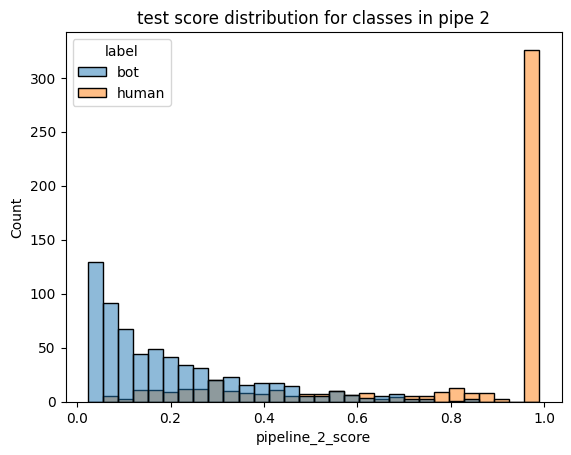

In [ ]:
sns.histplot(data=df[test_mask], x="pipeline_2_score", hue="label", bins = 30)
plt.title(f"test score distribution for classes in pipe 2")

Text(0.5, 1.0, 'test score distribution for classes in pipe 3 (non verified)')

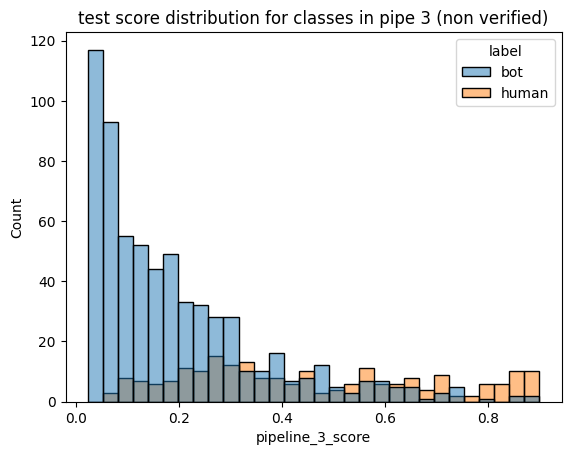

In [ ]:
sns.histplot(data=df[test_mask][lambda d: d.verified == 0], x="pipeline_3_score", hue="label", bins = 30)
plt.title(f"test score distribution for classes in pipe 3 (non verified)")

# Feature importances

## Calc SHAP Values

In [ ]:
model_1 = joblib.load(data_folder_path/"final_model_1.pkl")
model_2 =joblib.load(data_folder_path/"final_model_2.pkl")
model_3 =joblib.load(data_folder_path/"final_model_3.pkl")

model_2a =joblib.load(data_folder_path/"final_model_2a.pkl")
model_3a =joblib.load(data_folder_path/"final_model_3a.pkl")


explainer_1 = shap.TreeExplainer(model_1)
explainer_2 = shap.TreeExplainer(model_2)
explainer_3 = shap.TreeExplainer(model_3)
explainer_2a = shap.TreeExplainer(model_2a)
explainer_3a = shap.TreeExplainer(model_3a)


In [ ]:

df_shap_1 = explainer_1.shap_values(df[model_1_features])[-1]
df_shap_2 = explainer_2.shap_values(df[model_2_features])[-1]
df_shap_3 = explainer_3.shap_values(df[model_3_features])[-1]

df_shap_1 = pd.DataFrame(df_shap_1, columns = model_1_features).assign(label = df.label.values, split = df.split.values)
df_shap_2 = pd.DataFrame(df_shap_2, columns = model_2_features).assign(label = df.label.values, split = df.split.values)
df_shap_3 = pd.DataFrame(df_shap_3, columns = model_3_features).assign(label = df.label.values, split = df.split.values)

df_shap_1 = pd.concat(
    [
        df[df_shap_1.columns].assign(
            feature_value = "value", id = lambda d: np.arange(len(d))),
        df_shap_1.assign(
            feature_value = "shap_value", id = lambda d: np.arange(len(d))),
    ]
)

df_shap_2 = pd.concat(
    [
        df[df_shap_2.columns].assign(
            feature_value = "value", id = lambda d: np.arange(len(d))),
        df_shap_2.assign(
            feature_value = "shap_value", id = lambda d: np.arange(len(d))),
    ]
)

df_shap_3 = pd.concat(
    [
        df[df_shap_3.columns].assign(
            feature_value = "value", id = lambda d: np.arange(len(d))),
        df_shap_3.assign(
            feature_value = "shap_value", id = lambda d: np.arange(len(d))),
    ]
)


df_shap_1.to_parquet(data_folder_path/"shap_model_1.parquet")
df_shap_2.to_parquet(data_folder_path/"shap_model_2.parquet")
df_shap_3.to_parquet(data_folder_path/"shap_model_3.parquet")

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


## Plots

In [ ]:
# exp_1 = explainer_1(df[test_mask][model_1_features])
# exp_2 = explainer_2(df[test_mask][model_2_features])
# exp_3 = explainer_3(df[test_mask][model_3_features])

exp_2a = explainer_2a(df[test_mask][model_2a_features])
exp_3a = explainer_3a(df[test_mask][model_3a_features])

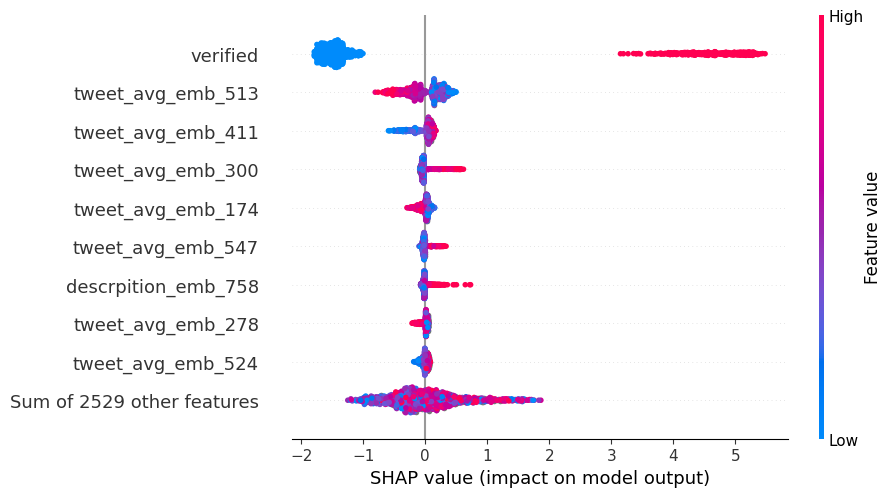

In [ ]:
shap.plots.beeswarm(exp_1[:,:,-1])


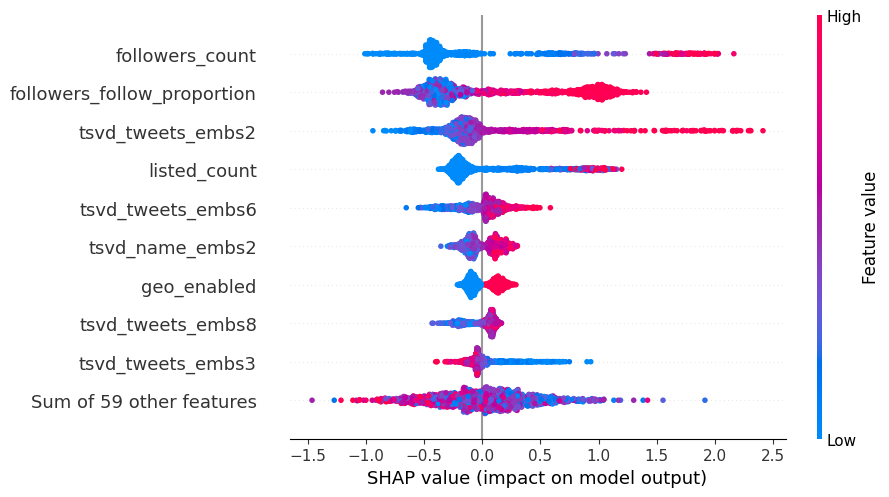

In [ ]:
shap.plots.beeswarm(exp_2a[:,:,-1])

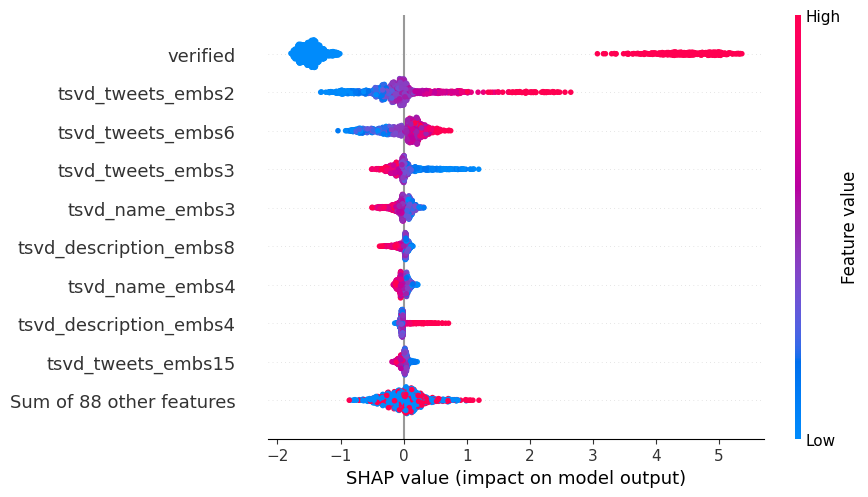

Text(0.5, 1.0, 'pipeline 1 beesworm plot')

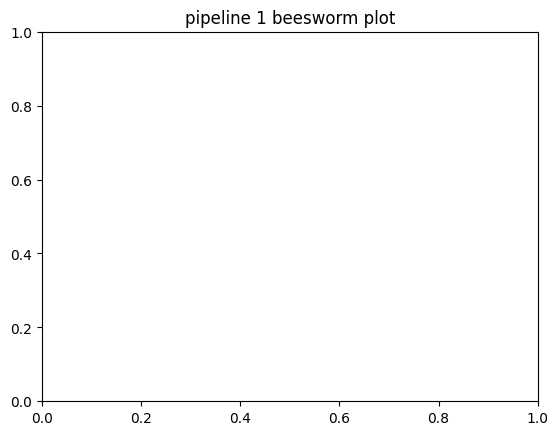

In [ ]:
shap.plots.beeswarm(exp_2[:,:,-1])

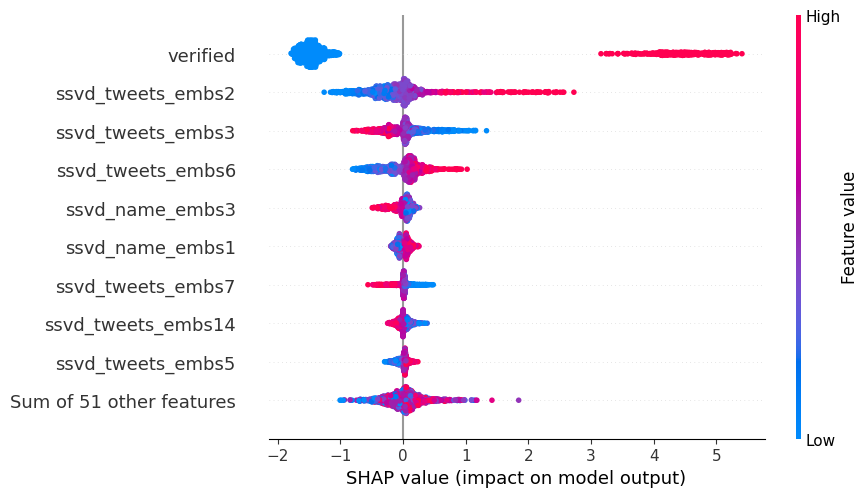

Text(0.5, 1.0, 'pipeline 1 beesworm plot')

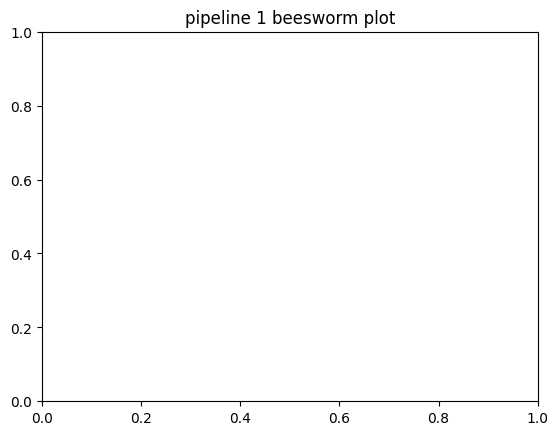

In [ ]:
shap.plots.beeswarm(exp_3[:,:,-1])
plt.title("pipeline 1 beesworm plot")

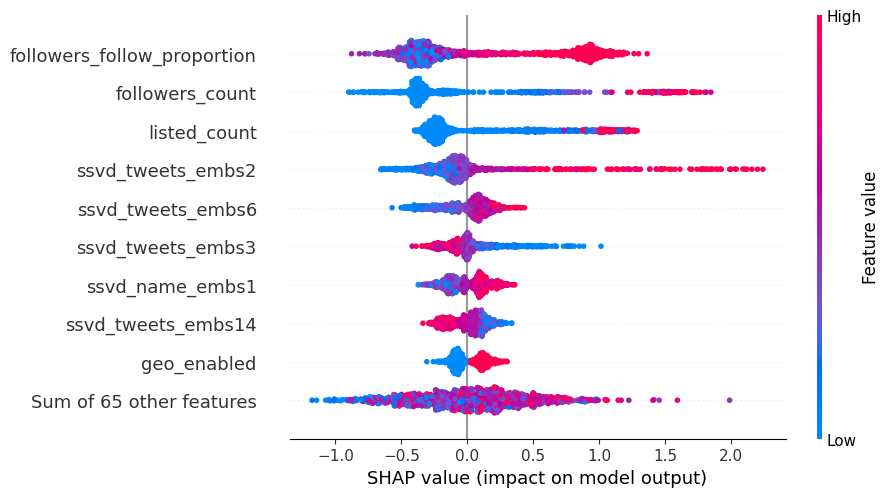

In [ ]:
shap.plots.beeswarm(exp_3a[:,:,-1])